In [20]:
import math
import os
import random
import sys
# import h5py
import logging
import numpy as np
from utils.data_utils import *
from models.motionpredictor import *
import torch
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt

In [21]:
args = {
    "learning_rate": 0.00001,
    "learning_rate_decay_factor": 0.95,
    "learning_rate_step": 10000,
    "batch_size": 128,
    "iterations": int(2e4),
    "test_every": 100,
    "size": 512,
    "seq_length_in": 50,
    "seq_length_out": 10,
    # Directories
    "data_dir": os.path.normpath("../data/h3.6m/dataset"),
    "train_dir": os.path.normpath("./experiments/"),
    "action": 'all',
    "log_level": 20,
    "log_file": ''
}

In [22]:
train_dir = os.path.normpath(os.path.join( args['train_dir'], args['action'],
	'out_{0}'.format(args['seq_length_out']),
	'iterations_{0}'.format(args['iterations']),
	'size_{0}'.format(args['size']),
	'lr_{0}'.format(args['learning_rate'])))

In [23]:
args['seq_length_out'] # Number of frames that the decoder has to predict

10

In [24]:
# Logging
if args['log_file']=='':
	logging.basicConfig(format='%(levelname)s: %(message)s',level=args['log_level'])
else:
	logging.basicConfig(filename=args['log_file'],format='%(levelname)s: %(message)s',level=args['log_level'])

In [25]:
# Detect device
if torch.cuda.is_available():
	logging.info(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
	logging.info("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO: NVIDIA GeForce RTX 3090


In [26]:
device

device(type='cuda')

In [27]:
logging.info("Train dir: "+train_dir)
os.makedirs(train_dir, exist_ok=True)

INFO: Train dir: experiments/all/out_10/iterations_20000/size_512/lr_1e-05


In [28]:
"""Train a seq2seq model on human motion"""
# Set of actions
actions           = define_actions( args['action'] ) # like "walking", "eating", "smoking", "discussion",  "directions", etc
number_of_actions = len( actions )

# Loads data for training/testing and normalizes it
# seq_length_in: number of frames to use in the burn-in sequence
# seq_length_out: number of frames to use in the output sequence
train_set, test_set, data_mean, data_std, dim_to_ignore, dim_to_use = read_all_data(actions, args['seq_length_in'], args['seq_length_out'], args['data_dir'])

INFO: Reading training data (seq_len_in: 50, seq_len_out 10).
INFO: Reading subject 1, action walking, subaction 1
INFO: Reading subject 1, action walking, subaction 2
INFO: Reading subject 1, action eating, subaction 1
INFO: Reading subject 1, action eating, subaction 2
INFO: Reading subject 1, action smoking, subaction 1
INFO: Reading subject 1, action smoking, subaction 2
INFO: Reading subject 1, action discussion, subaction 1
INFO: Reading subject 1, action discussion, subaction 2
INFO: Reading subject 1, action directions, subaction 1
INFO: Reading subject 1, action directions, subaction 2
INFO: Reading subject 1, action greeting, subaction 1
INFO: Reading subject 1, action greeting, subaction 2
INFO: Reading subject 1, action phoning, subaction 1
INFO: Reading subject 1, action phoning, subaction 2
INFO: Reading subject 1, action posing, subaction 1
INFO: Reading subject 1, action posing, subaction 2
INFO: Reading subject 1, action purchases, subaction 1
INFO: Reading subject 1, 

In [29]:
# Create model for training only
model = MotionPredictor(args['seq_length_in'], args['seq_length_out'],
    args['size'], # hidden layer size
    args['batch_size'], args['learning_rate'],
    args['learning_rate_decay_factor'],
    len( actions ))
model = model.to(device)

INFO: Input size is 69


In [30]:
model

MotionPredictor(
  (cell): GRUCell(69, 512)
  (fc1): Linear(in_features=512, out_features=69, bias=True)
  (fc_mean): Linear(in_features=512, out_features=512, bias=True)
  (fc_var): Linear(in_features=512, out_features=512, bias=True)
)

In [31]:
# This is the training loop
loss, val_loss = 0.0, 0.0
current_step   = 0
all_losses     = []
all_val_losses = []

# The optimizer
#optimiser = optim.SGD(model.parameters(), lr=args.learning_rate)
optimiser = optim.Adam(model.parameters(), lr=args['learning_rate'], betas = (0.9, 0.999))

In [32]:
for _ in range(args['iterations']):
	optimiser.zero_grad()
	# Set a flag to compute gradients
	model.train()
	# === Training step ===

	# Get batch from the training set
	encoder_inputs, decoder_inputs, decoder_outputs = model.get_batch(train_set,actions,device)

	# Forward pass
	preds, mu, logvar = model(encoder_inputs, decoder_inputs,device)

	# Loss: Mean Squared Errors
	rec_loss = (preds-decoder_outputs)**2
	kld_loss = -0.5 * (1 + logvar - mu**2 - torch.exp(logvar))
	step_loss = torch.mean(torch.sum(kld_loss, axis=1)) + rec_loss.mean()
	val_loss  = step_loss.mean()

	# step_loss = (preds-decoder_outputs)**2
	# step_loss = step_loss.mean()

	# Backpropagation
	step_loss.backward()
	# Gradient descent step
	optimiser.step()

	step_loss = step_loss.cpu().data.numpy()

	if current_step % 10 == 0:
		logging.info("step {0:04d}; step_loss: {1:.4f}".format(current_step, step_loss ))
	loss += step_loss / args['test_every']
	current_step += 1
	# === step decay ===
	if current_step % args['learning_rate_step'] == 0:
		args['learning_rate'] = args['learning_rate']*args['learning_rate_decay_factor']
		optimiser = optim.Adam(model.parameters(),lr=args['learning_rate'], betas = (0.9, 0.999))
		print("Decay learning rate. New value at " + str(args['learning_rate']))

	# Once in a while, save checkpoint, print statistics.
	if current_step % args['test_every'] == 0:
		model.eval()
		# === Validation ===
		encoder_inputs, decoder_inputs, decoder_outputs = model.get_batch(test_set,actions,device)
		preds, mu, logvar = model(encoder_inputs, decoder_inputs, device)

		step_loss = (preds-decoder_outputs)**2
		# kld_loss =-0.5 * (1 + logvar - mu**2 - torch.exp(logvar))
		# step_loss = torch.mean(torch.sum(kld_loss, axis=1)) + rec_loss
		val_loss  = step_loss.mean()

		print("\n============================\n"
			"Global step:         %d\n"
			"Learning rate:       %.4f\n"
			"Train loss avg:      %.4f\n"
			"--------------------------\n"
			"Val loss:            %.4f\n"
			"============================\n" % (current_step,
			args['learning_rate'], loss,val_loss))
		all_val_losses.append([current_step,val_loss.cpu().detach().numpy()])
		all_losses.append([current_step,loss])
		torch.save(model, train_dir + '/model_' + str(current_step))
		# Reset loss
		loss = 0

INFO: step 0000; step_loss: 9.4195
INFO: step 0010; step_loss: 8.6104
INFO: step 0020; step_loss: 8.3881
INFO: step 0030; step_loss: 8.7029
INFO: step 0040; step_loss: 7.9822
INFO: step 0050; step_loss: 7.8170
INFO: step 0060; step_loss: 8.0440
INFO: step 0070; step_loss: 7.3383
INFO: step 0080; step_loss: 7.4395
INFO: step 0090; step_loss: 7.4545
INFO: step 0100; step_loss: 7.2152



Global step:         100
Learning rate:       0.0000
Train loss avg:      8.0931
--------------------------
Val loss:            1.0328



INFO: step 0110; step_loss: 7.4384
INFO: step 0120; step_loss: 7.0064
INFO: step 0130; step_loss: 7.1717
INFO: step 0140; step_loss: 7.4223
INFO: step 0150; step_loss: 6.5549
INFO: step 0160; step_loss: 6.3093
INFO: step 0170; step_loss: 6.9458
INFO: step 0180; step_loss: 7.0900
INFO: step 0190; step_loss: 5.9221
INFO: step 0200; step_loss: 6.0044



Global step:         200
Learning rate:       0.0000
Train loss avg:      6.8519
--------------------------
Val loss:            0.8727



INFO: step 0210; step_loss: 6.0687
INFO: step 0220; step_loss: 5.9591
INFO: step 0230; step_loss: 5.2471
INFO: step 0240; step_loss: 6.3810
INFO: step 0250; step_loss: 5.3368
INFO: step 0260; step_loss: 5.5920
INFO: step 0270; step_loss: 4.9957
INFO: step 0280; step_loss: 5.3411
INFO: step 0290; step_loss: 5.7792
INFO: step 0300; step_loss: 5.0582



Global step:         300
Learning rate:       0.0000
Train loss avg:      5.7095
--------------------------
Val loss:            0.7498



INFO: step 0310; step_loss: 5.4397
INFO: step 0320; step_loss: 4.8437
INFO: step 0330; step_loss: 4.7367
INFO: step 0340; step_loss: 4.9011
INFO: step 0350; step_loss: 4.7429
INFO: step 0360; step_loss: 4.5369
INFO: step 0370; step_loss: 5.0648
INFO: step 0380; step_loss: 4.6812
INFO: step 0390; step_loss: 4.9294
INFO: step 0400; step_loss: 4.6757



Global step:         400
Learning rate:       0.0000
Train loss avg:      4.9597
--------------------------
Val loss:            0.6779



INFO: step 0410; step_loss: 4.6102
INFO: step 0420; step_loss: 4.2377
INFO: step 0430; step_loss: 4.6718
INFO: step 0440; step_loss: 4.4186
INFO: step 0450; step_loss: 4.9534
INFO: step 0460; step_loss: 4.1388
INFO: step 0470; step_loss: 4.3511
INFO: step 0480; step_loss: 4.4626
INFO: step 0490; step_loss: 4.2246
INFO: step 0500; step_loss: 3.8246



Global step:         500
Learning rate:       0.0000
Train loss avg:      4.4131
--------------------------
Val loss:            0.6395



INFO: step 0510; step_loss: 4.3133
INFO: step 0520; step_loss: 4.1210
INFO: step 0530; step_loss: 3.7685
INFO: step 0540; step_loss: 3.9590
INFO: step 0550; step_loss: 4.3573
INFO: step 0560; step_loss: 4.4726
INFO: step 0570; step_loss: 3.7285
INFO: step 0580; step_loss: 4.2259
INFO: step 0590; step_loss: 3.7916
INFO: step 0600; step_loss: 3.7609



Global step:         600
Learning rate:       0.0000
Train loss avg:      3.9575
--------------------------
Val loss:            0.5944



INFO: step 0610; step_loss: 3.7051
INFO: step 0620; step_loss: 3.4769
INFO: step 0630; step_loss: 3.4312
INFO: step 0640; step_loss: 3.6292
INFO: step 0650; step_loss: 3.5829
INFO: step 0660; step_loss: 3.5208
INFO: step 0670; step_loss: 3.6141
INFO: step 0680; step_loss: 3.2951
INFO: step 0690; step_loss: 3.2574
INFO: step 0700; step_loss: 3.6743



Global step:         700
Learning rate:       0.0000
Train loss avg:      3.5961
--------------------------
Val loss:            0.5527



INFO: step 0710; step_loss: 3.4249
INFO: step 0720; step_loss: 3.3992
INFO: step 0730; step_loss: 3.2097
INFO: step 0740; step_loss: 2.8691
INFO: step 0750; step_loss: 3.7434
INFO: step 0760; step_loss: 3.4495
INFO: step 0770; step_loss: 3.1194
INFO: step 0780; step_loss: 3.2817
INFO: step 0790; step_loss: 2.9254



Global step:         800
Learning rate:       0.0000
Train loss avg:      3.3203
--------------------------
Val loss:            0.6615



INFO: step 0800; step_loss: 3.4076
INFO: step 0810; step_loss: 3.5004
INFO: step 0820; step_loss: 3.6536
INFO: step 0830; step_loss: 3.0475
INFO: step 0840; step_loss: 2.8306
INFO: step 0850; step_loss: 2.9823
INFO: step 0860; step_loss: 2.9467
INFO: step 0870; step_loss: 2.8991
INFO: step 0880; step_loss: 3.1265
INFO: step 0890; step_loss: 2.9638
INFO: step 0900; step_loss: 2.7035



Global step:         900
Learning rate:       0.0000
Train loss avg:      3.0026
--------------------------
Val loss:            0.5334



INFO: step 0910; step_loss: 2.8548
INFO: step 0920; step_loss: 2.5712
INFO: step 0930; step_loss: 2.6770
INFO: step 0940; step_loss: 2.5662
INFO: step 0950; step_loss: 2.8606
INFO: step 0960; step_loss: 2.9174
INFO: step 0970; step_loss: 2.5745
INFO: step 0980; step_loss: 2.6786
INFO: step 0990; step_loss: 2.7779
INFO: step 1000; step_loss: 2.4349



Global step:         1000
Learning rate:       0.0000
Train loss avg:      2.7469
--------------------------
Val loss:            0.5098



INFO: step 1010; step_loss: 2.6505
INFO: step 1020; step_loss: 2.8315
INFO: step 1030; step_loss: 2.6939
INFO: step 1040; step_loss: 2.7465
INFO: step 1050; step_loss: 2.7046
INFO: step 1060; step_loss: 2.2476
INFO: step 1070; step_loss: 2.5760
INFO: step 1080; step_loss: 2.5452
INFO: step 1090; step_loss: 2.6101
INFO: step 1100; step_loss: 2.4706



Global step:         1100
Learning rate:       0.0000
Train loss avg:      2.5653
--------------------------
Val loss:            0.4755



INFO: step 1110; step_loss: 2.6963
INFO: step 1120; step_loss: 2.3381
INFO: step 1130; step_loss: 2.3440
INFO: step 1140; step_loss: 2.1988
INFO: step 1150; step_loss: 2.4923
INFO: step 1160; step_loss: 2.1688
INFO: step 1170; step_loss: 2.4323
INFO: step 1180; step_loss: 2.2652
INFO: step 1190; step_loss: 2.4200
INFO: step 1200; step_loss: 2.1669



Global step:         1200
Learning rate:       0.0000
Train loss avg:      2.3710
--------------------------
Val loss:            0.4644



INFO: step 1210; step_loss: 2.1950
INFO: step 1220; step_loss: 2.2030
INFO: step 1230; step_loss: 2.0894
INFO: step 1240; step_loss: 2.3103
INFO: step 1250; step_loss: 2.1823
INFO: step 1260; step_loss: 2.2173
INFO: step 1270; step_loss: 2.2695
INFO: step 1280; step_loss: 2.3284
INFO: step 1290; step_loss: 1.8610
INFO: step 1300; step_loss: 2.2073



Global step:         1300
Learning rate:       0.0000
Train loss avg:      2.2106
--------------------------
Val loss:            0.4599



INFO: step 1310; step_loss: 2.2505
INFO: step 1320; step_loss: 2.2637
INFO: step 1330; step_loss: 1.9613
INFO: step 1340; step_loss: 2.0803
INFO: step 1350; step_loss: 2.1568
INFO: step 1360; step_loss: 2.1582
INFO: step 1370; step_loss: 2.0008
INFO: step 1380; step_loss: 2.0618
INFO: step 1390; step_loss: 1.9166
INFO: step 1400; step_loss: 1.8559



Global step:         1400
Learning rate:       0.0000
Train loss avg:      2.0597
--------------------------
Val loss:            0.4500



INFO: step 1410; step_loss: 1.8365
INFO: step 1420; step_loss: 2.0207
INFO: step 1430; step_loss: 2.0495
INFO: step 1440; step_loss: 2.0817
INFO: step 1450; step_loss: 1.8780
INFO: step 1460; step_loss: 1.8839
INFO: step 1470; step_loss: 1.7805
INFO: step 1480; step_loss: 1.9251
INFO: step 1490; step_loss: 1.9019
INFO: step 1500; step_loss: 1.8297



Global step:         1500
Learning rate:       0.0000
Train loss avg:      1.9612
--------------------------
Val loss:            0.4357



INFO: step 1510; step_loss: 1.8117
INFO: step 1520; step_loss: 2.0412
INFO: step 1530; step_loss: 1.8057
INFO: step 1540; step_loss: 1.8360
INFO: step 1550; step_loss: 1.8250
INFO: step 1560; step_loss: 1.6494
INFO: step 1570; step_loss: 1.8001
INFO: step 1580; step_loss: 1.7156
INFO: step 1590; step_loss: 1.8193
INFO: step 1600; step_loss: 1.7233



Global step:         1600
Learning rate:       0.0000
Train loss avg:      1.8441
--------------------------
Val loss:            0.4450



INFO: step 1610; step_loss: 1.8591
INFO: step 1620; step_loss: 1.6352
INFO: step 1630; step_loss: 1.8426
INFO: step 1640; step_loss: 1.6500
INFO: step 1650; step_loss: 1.6958
INFO: step 1660; step_loss: 1.7428
INFO: step 1670; step_loss: 1.5615
INFO: step 1680; step_loss: 1.7786
INFO: step 1690; step_loss: 1.8673
INFO: step 1700; step_loss: 1.7132



Global step:         1700
Learning rate:       0.0000
Train loss avg:      1.7364
--------------------------
Val loss:            0.4824



INFO: step 1710; step_loss: 1.8303
INFO: step 1720; step_loss: 1.4772
INFO: step 1730; step_loss: 1.6905
INFO: step 1740; step_loss: 1.5255
INFO: step 1750; step_loss: 1.6236
INFO: step 1760; step_loss: 1.5842
INFO: step 1770; step_loss: 1.8503
INFO: step 1780; step_loss: 1.5091
INFO: step 1790; step_loss: 1.7820
INFO: step 1800; step_loss: 1.7497



Global step:         1800
Learning rate:       0.0000
Train loss avg:      1.6433
--------------------------
Val loss:            0.3993



INFO: step 1810; step_loss: 1.7025
INFO: step 1820; step_loss: 1.5603
INFO: step 1830; step_loss: 1.4943
INFO: step 1840; step_loss: 1.6826
INFO: step 1850; step_loss: 1.5947
INFO: step 1860; step_loss: 1.4188
INFO: step 1870; step_loss: 1.5800
INFO: step 1880; step_loss: 1.7253
INFO: step 1890; step_loss: 1.5112
INFO: step 1900; step_loss: 1.4324



Global step:         1900
Learning rate:       0.0000
Train loss avg:      1.5671
--------------------------
Val loss:            0.3733



INFO: step 1910; step_loss: 1.3410
INFO: step 1920; step_loss: 1.5038
INFO: step 1930; step_loss: 1.4958
INFO: step 1940; step_loss: 1.5948
INFO: step 1950; step_loss: 1.4733
INFO: step 1960; step_loss: 1.4650
INFO: step 1970; step_loss: 1.4226
INFO: step 1980; step_loss: 1.4430
INFO: step 1990; step_loss: 1.5738
INFO: step 2000; step_loss: 1.3753



Global step:         2000
Learning rate:       0.0000
Train loss avg:      1.4799
--------------------------
Val loss:            0.3895



INFO: step 2010; step_loss: 1.3128
INFO: step 2020; step_loss: 1.4654
INFO: step 2030; step_loss: 1.4121
INFO: step 2040; step_loss: 1.5212
INFO: step 2050; step_loss: 1.4033
INFO: step 2060; step_loss: 1.3583
INFO: step 2070; step_loss: 1.4100
INFO: step 2080; step_loss: 1.4375
INFO: step 2090; step_loss: 1.4299
INFO: step 2100; step_loss: 1.2832



Global step:         2100
Learning rate:       0.0000
Train loss avg:      1.4118
--------------------------
Val loss:            0.3853



INFO: step 2110; step_loss: 1.3375
INFO: step 2120; step_loss: 1.3856
INFO: step 2130; step_loss: 1.2967
INFO: step 2140; step_loss: 1.3082
INFO: step 2150; step_loss: 1.3221
INFO: step 2160; step_loss: 1.2273
INFO: step 2170; step_loss: 1.3184
INFO: step 2180; step_loss: 1.3845
INFO: step 2190; step_loss: 1.2703
INFO: step 2200; step_loss: 1.2952



Global step:         2200
Learning rate:       0.0000
Train loss avg:      1.3438
--------------------------
Val loss:            0.3493



INFO: step 2210; step_loss: 1.2905
INFO: step 2220; step_loss: 1.2691
INFO: step 2230; step_loss: 1.2650
INFO: step 2240; step_loss: 1.3856
INFO: step 2250; step_loss: 1.2776
INFO: step 2260; step_loss: 1.2295
INFO: step 2270; step_loss: 1.2767
INFO: step 2280; step_loss: 1.2927
INFO: step 2290; step_loss: 1.2275
INFO: step 2300; step_loss: 1.2826



Global step:         2300
Learning rate:       0.0000
Train loss avg:      1.2766
--------------------------
Val loss:            0.3199



INFO: step 2310; step_loss: 1.2283
INFO: step 2320; step_loss: 1.2634
INFO: step 2330; step_loss: 1.2661
INFO: step 2340; step_loss: 1.2471
INFO: step 2350; step_loss: 1.1994
INFO: step 2360; step_loss: 1.1782
INFO: step 2370; step_loss: 1.1643
INFO: step 2380; step_loss: 1.2217
INFO: step 2390; step_loss: 1.2091
INFO: step 2400; step_loss: 1.2126



Global step:         2400
Learning rate:       0.0000
Train loss avg:      1.2209
--------------------------
Val loss:            0.3323



INFO: step 2410; step_loss: 1.1954
INFO: step 2420; step_loss: 1.1767
INFO: step 2430; step_loss: 1.1384


KeyboardInterrupt: 

In [ ]:
vlosses = np.array(all_val_losses)
tlosses = np.array(all_losses)

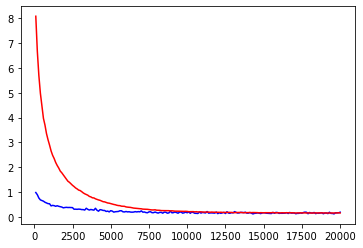

In [15]:
# Plot losses
plt.plot(vlosses[:,0],vlosses[:,1],'b')
plt.plot(tlosses[:,0],tlosses[:,1],'r')
plt.show()

In [16]:
np.save("CVAE01.npy", vlosses)

In [17]:
n_params = 0
for p in model.parameters():
    n_params += np.prod(p.shape)

print("Parámeters: {0:,}".format(n_params)) 

Parámeters: 1,456,197


In [33]:
bl = np.load("CVAE01.npy")

In [34]:
np.min(bl)

0.11384981125593185